In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score


   patient_id  age  gender  blood_pressure_systolic  blood_pressure_diastolic  \
0           1   56    Male                      168                       109   
1           2   69    Male                       96                        90   
2           3   46  Female                       98                       115   
3           4   32    Male                      137                        74   
4           5   60    Male                      161                        68   

   cholesterol  glucose  hemoglobin  white_blood_cells  platelets   bmi  \
0          214      142        17.2                7.7     353299  28.9   
1          157      115        17.9                9.7     209321  22.2   
2          194      175        12.5                9.1     283835  10.8   
3          236      101        14.0                5.9     170389  31.8   
4          225       75        14.4                5.5     181498  28.8   

  smoking_status exercise_frequency  has_diabetes  has_hyperte

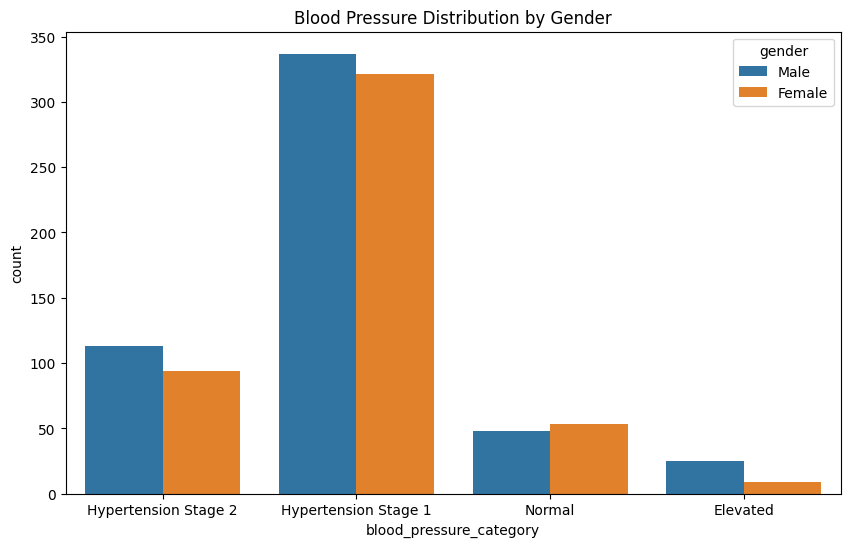

In [14]:
# Load the dataset
health_data = pd.read_csv('healthcare_dataset.csv')

# Basic exploration - WORKS
print(health_data.head())
print(health_data.info())

# Check recommendation distribution - WORKS
print(health_data['recommendation'].value_counts())

# Visualization - WORKS
plt.figure(figsize=(10,6))
sns.countplot(data=health_data, x='blood_pressure_category', hue='gender')
plt.title('Blood Pressure Distribution by Gender')
plt.show()

In [15]:

# Identify feature types
numerical_features = ['age', 'hemoglobin', 'glucose', 'cholesterol']
categorical_features = ['gender', 'smoking_status']

# Create preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Split data
X = data.drop('recommendation', axis=1)
y = data['recommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Create pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train model
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")

C:\Users\Ayush Agrawal\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ayush Agrawal\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ayush Agrawal\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

                                                                                                                                      precision    recall  f1-score   support

                                                                                                           Blood pressure management       0.00      0.00      0.00         1
                                                                                      Blood pressure management, Cholesterol control       0.29      0.50      0.36         4
                                                                  Blood pressure management, Cholesterol control, Diabetes screening       0.00      0.00      0.00         4
                                                  Blood pressure management, Cholesterol control, Diabetes screening, Healthy eating       0.20      0.33      0.25         3
                      Blood pressure management, Cholesterol control, Diabetes screening, Healthy eating, Increase physical activ

In [19]:
def generate_enhanced_recommendation(patient_data):
    # Get prediction and probabilities
    patient_df = pd.DataFrame([patient_data])
    recommendation = model.predict(patient_df)[0]
    probabilities = model.predict_proba(patient_df)[0]
    
    # Get all recommendations with probabilities
    classes = model.named_steps['classifier'].classes_
    recommendations_with_probs = sorted(zip(classes, probabilities), key=lambda x: x[1], reverse=True)
    
    # Split combined recommendations into individual actions
    def split_recommendations(rec):
        return [r.strip() for r in rec.split(',')]
    
    # Create priority-based recommendations
    all_actions = []
    for rec, prob in recommendations_with_probs[:3]:  # Top 3 most probable
        all_actions.extend(split_recommendations(rec))
    
    # Remove duplicates and create priority list
    unique_actions = []
    [unique_actions.append(action) for action in all_actions if action not in unique_actions]
    
    # Categorize by urgency
    urgency_map = {
        'Blood pressure management': 'high',
        'Diabetes screening': 'high',
        'Smoking cessation': 'high',
        'Cholesterol control': 'medium',
        'Weight management': 'medium',
        'Monitor blood sugar': 'medium',
        'Healthy eating': 'low',
        'Increase physical activity': 'low',
        'Maintain current lifestyle': 'none'
    }
    
    # Group by urgency
    prioritized_recommendations = {
        'high_priority': [action for action in unique_actions if urgency_map.get(action) == 'high'],
        'medium_priority': [action for action in unique_actions if urgency_map.get(action) == 'medium'],
        'low_priority': [action for action in unique_actions if urgency_map.get(action) == 'low']
    }
    
    return {
        'prioritized_recommendations': prioritized_recommendations,
        'confidence': f"{max(probabilities)*100:.1f}%",
        'clinical_notes': generate_clinical_notes(patient_data)
    }

def generate_clinical_notes(patient_data):
    notes = []
    
    # Blood pressure notes
    if patient_data['blood_pressure_systolic'] >= 140 or patient_data['blood_pressure_diastolic'] >= 90:
        notes.append(f"Elevated blood pressure ({patient_data['blood_pressure_systolic']}/{patient_data['blood_pressure_diastolic']}) - consider monitoring")
    
    # Glucose notes
    if patient_data['glucose'] >= 126:
        notes.append(f"Elevated glucose level ({patient_data['glucose']} mg/dL) - potential diabetes risk")
    elif patient_data['glucose'] >= 100:
        notes.append(f"Borderline glucose level ({patient_data['glucose']} mg/dL)")
    
    # Cholesterol notes
    if patient_data['cholesterol'] >= 240:
        notes.append(f"High cholesterol ({patient_data['cholesterol']} mg/dL)")
    
    # Lifestyle notes
    if patient_data['smoking_status'] == 'Current smoker':
        notes.append("Patient currently smokes - cessation recommended")
    
    if patient_data['exercise_frequency'] in ['Sedentary', 'Light']:
        notes.append("Low physical activity level detected")
    
    return notes if notes else ["No critical health markers detected"]

In [20]:
def generate_treatment_plan(patient_data):
    recommendations = generate_enhanced_recommendation(patient_data)
    
    plan = {
        'patient_summary': {
            'age': patient_data['age'],
            'gender': patient_data['gender'],
            'bmi': patient_data['bmi'],
            'risk_factors': [
                f for f in [
                    'smoker' if patient_data['smoking_status'] == 'Current smoker' else None,
                    'sedentary' if patient_data['exercise_frequency'] in ['Sedentary', 'Light'] else None,
                    'obese' if patient_data['bmi'] >= 30 else None,
                    'hypertensive' if patient_data['has_hypertension'] == 1 else None
                ] if f is not None
            ]
        },
        'recommendations': recommendations,
        'monitoring_schedule': generate_monitoring_schedule(patient_data)
    }
    
    return plan

def generate_monitoring_schedule(patient_data):
    schedule = []
    
    # Blood pressure monitoring
    bp_freq = 'weekly' if (patient_data['blood_pressure_systolic'] >= 130 or 
                          patient_data['blood_pressure_diastolic'] >= 85) else 'monthly'
    schedule.append(f"Blood pressure monitoring: {bp_freq}")
    
    # Blood tests
    if patient_data['cholesterol'] >= 200 or patient_data['glucose'] >= 100:
        schedule.append("Blood work: Repeat in 3 months")
    
    return schedule

In [21]:
def clinical_decision_support(patient_data):
    alerts = []
    
    # Critical value alerts
    if patient_data['glucose'] >= 200:
        alerts.append({
            'type': 'critical',
            'message': 'Severe hyperglycemia detected - immediate medical attention recommended',
            'action': 'Refer to endocrinologist'
        })
    
    if patient_data['blood_pressure_systolic'] >= 180 or patient_data['blood_pressure_diastolic'] >= 120:
        alerts.append({
            'type': 'critical',
            'message': 'Hypertensive crisis - urgent intervention needed',
            'action': 'Immediate medical evaluation'
        })
    
    # Warning alerts
    elif patient_data['blood_pressure_systolic'] >= 140 or patient_data['blood_pressure_diastolic'] >= 90:
        alerts.append({
            'type': 'warning',
            'message': 'Stage 2 hypertension',
            'action': 'Schedule follow-up within 1 week'
        })
    
    if patient_data['cholesterol'] >= 240:
        alerts.append({
            'type': 'warning',
            'message': 'High cholesterol - consider lipid-lowering therapy',
            'action': 'Discuss statin therapy options'
        })
    
    return alerts if alerts else [{
        'type': 'info',
        'message': 'No critical alerts at this time',
        'action': 'Routine monitoring'
    }]

In [24]:
def comprehensive_health_assessment(patient_data):
    # Generate all components
    treatment_plan = generate_treatment_plan(patient_data)
    decision_support = clinical_decision_support(patient_data)
    
    # Format for clinical use
    report = {
        'patient_identifier': f"{patient_data['gender'][0]}-{patient_data['age']}-{str(hash(frozenset(patient_data.items())))[:6]}",
        'date_generated': pd.Timestamp.now().strftime('%Y-%m-%d'),
        'vital_statistics': {
            'blood_pressure': f"{patient_data['blood_pressure_systolic']}/{patient_data['blood_pressure_diastolic']}",
            'cholesterol': patient_data['cholesterol'],
            'glucose': patient_data['glucose'],
            'bmi': patient_data['bmi']
        },
        'alerts': decision_support,
        'personalized_recommendations': treatment_plan['recommendations'],
        'monitoring_plan': treatment_plan['monitoring_schedule'],
        'lifestyle_modifications': [
            rec for rec in treatment_plan['recommendations']['prioritized_recommendations']['low_priority']
            if rec not in ['Maintain current lifestyle']
        ]
    }
    
    # Add clinical summary
    critical_count = sum(1 for alert in decision_support if alert['type'] == 'critical')
    report['summary'] = (
        f"{critical_count} critical alert(s) detected. " +
        f"{len(report['personalized_recommendations']['prioritized_recommendations']['high_priority'])} " +
        "high priority recommendations."
    )
    
    return report

In [25]:
# Using your previous example patient
enhanced_report = comprehensive_health_assessment(example_patient)

# Print formatted output
import json
print(json.dumps(enhanced_report, indent=2))

{
  "patient_identifier": "M-45-806524",
  "date_generated": "2025-07-09",
  "vital_statistics": {
    "blood_pressure": "142/92",
    "cholesterol": 210,
    "glucose": 98,
    "bmi": 28.5
  },
  "alerts": [
    {
      "type": "warning",
      "message": "Stage 2 hypertension",
      "action": "Schedule follow-up within 1 week"
    }
  ],
  "personalized_recommendations": {
    "prioritized_recommendations": {
      "high_priority": [
        "Smoking cessation",
        "Blood pressure management"
      ],
      "medium_priority": [
        "Monitor blood sugar"
      ],
      "low_priority": [
        "Healthy eating"
      ]
    },
    "confidence": "15.0%",
    "clinical_notes": [
      "Elevated blood pressure (142/92) - consider monitoring",
      "Patient currently smokes - cessation recommended",
      "Low physical activity level detected"
    ]
  },
  "monitoring_plan": [
    "Blood pressure monitoring: weekly",
    "Blood work: Repeat in 3 months"
  ],
  "lifestyle_modific